<a href="https://colab.research.google.com/github/godwins3/Kenyan_Sign_Language/blob/main/Task_Mate_Kenyan_Sign_Language_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -q  fastai
#!pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torch

In [ ]:
# check version of fastai
import fastai

fastai.__version__

'2.7.10'

In [ ]:
import torch

torch.__version__

'1.12.1+cu113'

In [ ]:
# connect to gdrive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import numpy as np 
import pandas as pd 

import torch
import fastai
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from fastai.vision.all import *
from fastai.vision.augment import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
image_path = "/content/gdrive/MyDrive/Sign-Language-Classification-Hackathon/images-clean"

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Sign-Language-Classification-Hackathon/Train.csv")
df

,img_IDS,Label
0,ImageID_33HMDMJ3,Temple
1,ImageID_V5POEX4O,Church
2,ImageID_89CCCCW6,Enough/Satisfied
3,ImageID_GNJXOWX5,Me
4,ImageID_7Q9LOP7R,Love
...,...,...
6244,ImageID_F2HTAA5P,Love
6245,ImageID_0D69ZQ4X,Church
6246,ImageID_E67IZXVJ,Seat
6247,ImageID_ENGL8NP3,You


Modify Image IDS column so that it becomes a direct path to image location

In [ ]:
df1 = df.copy() 
df1['img_IDS'] = df1['img_IDS'] +".png"
df1

,img_IDS,Label
0,ImageID_33HMDMJ3.png,Temple
1,ImageID_V5POEX4O.png,Church
2,ImageID_89CCCCW6.png,Enough/Satisfied
3,ImageID_GNJXOWX5.png,Me
4,ImageID_7Q9LOP7R.png,Love
...,...,...
6244,ImageID_F2HTAA5P.png,Love
6245,ImageID_0D69ZQ4X.png,Church
6246,ImageID_E67IZXVJ.png,Seat
6247,ImageID_ENGL8NP3.png,You


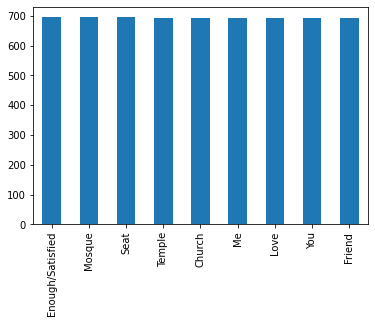

In [ ]:
df1['Label'].value_counts().plot.bar()

Image Resizer

In [ ]:
import os
from multiprocessing import Pool, cpu_count
import shutil

try:
  
    os.mkdir("ModImages")
except:
    pass

def reduce_size(img_path):
    basewidth = 720
    # open where your image is stored 
    img = Image.open("/content/gdrive/MyDrive/Sign-Language-Classification-Hackathon/Images-"+img_path)  
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    img.save("ModImages/"+img_path)

In [ ]:
%%time
## takes about 9 minutes to run
# Pool(cpu_count()) as p:
 #   p.map(reduce_size, os.listdir("/content/gdrive/MyDrive/Sign-Language-Classification-Hackathon/Images"))
    

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs


In [ ]:
# store the modified Images where the original folder is in your drive

!zip -r ModImages.zip /content/ModImages -q
!cp ModImages.zip /content/gdrive/MyDrive/sign_prediction


Image Data Loader

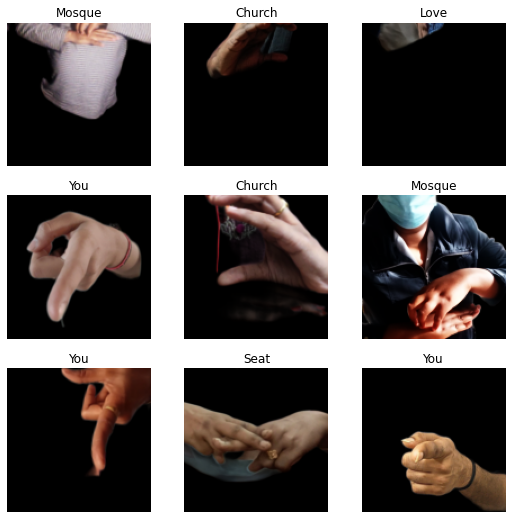

In [ ]:
img_size = 128
augmentations = [
        Rotate(10, p=0.4, mode='bilinear'), 
        Brightness(max_lighting=0.3,p=0.5),
        Contrast(max_lighting=0.4, p=0.5),
        #RandomErasing(p=0.3, sl=0.0, sh=0.2, min_aspect=0.3, max_count=1),
        Flip(p=0.5),
        Zoom(max_zoom=1,p=0.5),
        RandomResizedCrop(img_size)
    ]
dls = ImageDataLoaders.from_df(df=df1,
                               path=image_path,
                               valid_pct = 0.2, 
                               bs = 32, 
                               device=device, 
                               num_workers=0, 
                               batch_tfms=augmentations, 
                               item_tfms=Resize(img_size))
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, 
                    resnet50, 
                    metrics=[accuracy,error_rate])
learn.lr_find()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#learn.fit_one_cycle(epochs, lr, wd)

### Create a baseline model using resnet18

In [ ]:
# Fit
learning_rate = [1e-5, 1e-4, 5e-4]
num_epochs = 10
learn.fit_one_cycle(num_epochs, learning_rate)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.501432,1.471829,0.530825,0.469175,35:57
1,1.887290,1.262745,0.618895,0.381105,20:10
2,1.649189,1.144987,0.654123,0.345877,20:12
3,1.420387,1.067809,0.662930,0.337070,20:08
4,1.269359,0.958447,0.680544,0.319456,20:08
5,1.167042,0.923418,0.689351,0.310649,20:07
6,1.067367,0.898294,0.708567,0.291433,20:00
7,1.012660,0.884018,0.703763,0.296237,20:05
8,0.957666,0.876833,0.714171,0.285829,20:03
9,0.978353,0.873142,0.716573,0.283427,20:03


In [ ]:
learn.export('/content/gdrive/MyDrive/Sign-Language-Classification-Hackathon/resnet50_export.pkl')

In [ ]:
learn = load_learner('/content/gdrive/MyDrive/Sign-Language-Classification-Hackathon/resnet50_export.pkl')

## predict on test set

In [ ]:
test_df = pd.read_csv("/content/gdrive/MyDrive/Sign-Language-Classification-Hackathon/Test.csv")

In [ ]:
test_df.head()

,img_IDS
0,ImageID_USRB8QNG
1,ImageID_SZ8D1ZJI
2,ImageID_4OJO2F8J
3,ImageID_IEE4XV0B
4,ImageID_BP0O0WZ9


In [ ]:
#test = ImageDataLoaders.from_df(test_df, image_path)
test=ImageDataLoaders.from_df(test_df, path=image_path, 
                               seed=None, fn_col=0, folder=None, suff='.png', 
                               label_col=0, label_delim=None, y_block=None, valid_col=None, item_tfms=None, 
                               batch_tfms=None, device=None)


In [ ]:
type(test)

fastai.data.core.DataLoaders

In [ ]:
test_df["img_IDS"]

0       ImageID_USRB8QNG
1       ImageID_SZ8D1ZJI
2       ImageID_4OJO2F8J
3       ImageID_IEE4XV0B
4       ImageID_BP0O0WZ9
              ...       
2674    ImageID_KZ958O2B
2675    ImageID_UFNEWZ6U
2676    ImageID_0IBAU19T
2677    ImageID_K6IAGP77
2678    ImageID_IKQQPMCC
Name: img_IDS, Length: 2679, dtype: object

In [ ]:
  tes = test_df.copy() 
tes['img_IDS'] = tes['img_IDS'] +".png"
tes

,img_IDS
0,ImageID_USRB8QNG.png
1,ImageID_SZ8D1ZJI.png
2,ImageID_4OJO2F8J.png
3,ImageID_IEE4XV0B.png
4,ImageID_BP0O0WZ9.png
...,...
2674,ImageID_KZ958O2B.png
2675,ImageID_UFNEWZ6U.png
2676,ImageID_0IBAU19T.png
2677,ImageID_K6IAGP77.png


In [ ]:
#test_dl = learn.dls.test_dl(test, bs=64) # Create a test dataloader
test_dl= learn.dls.test_dl(tes)


In [ ]:
type(test_dl)

fastai.data.core.TfmdDL

In [ ]:
preds,y_test = learn.get_preds(dl = test_dl)

In [ ]:
sub=pd.read_csv('/content/gdrive/MyDrive/Sign-Language-Classification-Hackathon/SampleSubmission.csv')


In [ ]:
sub1 = sub.copy() 
sub1['img_IDS'] = sub1['img_IDS'] +".jpg"
sub1

,img_IDS,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
0,ImageID_USRB8QNG.jpg,0,0,0,0,0,0,0,0,0
1,ImageID_SZ8D1ZJI.jpg,0,0,0,0,0,0,0,0,0
2,ImageID_4OJO2F8J.jpg,0,0,0,0,0,0,0,0,0
3,ImageID_IEE4XV0B.jpg,0,0,0,0,0,0,0,0,0
4,ImageID_BP0O0WZ9.jpg,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2674,ImageID_KZ958O2B.jpg,0,0,0,0,0,0,0,0,0
2675,ImageID_UFNEWZ6U.jpg,0,0,0,0,0,0,0,0,0
2676,ImageID_0IBAU19T.jpg,0,0,0,0,0,0,0,0,0
2677,ImageID_K6IAGP77.jpg,0,0,0,0,0,0,0,0,0


In [ ]:
preds[:,1]

TensorBase([0.8268, 0.4630, 0.1221,  ..., 0.0027, 0.0026, 0.0034])

In [ ]:
k=[] 

for col in sub. columns: 
  k.append(col)

cls = [

'Church', 'Enough/Satisfied',

'Friend', 'Love', 'Me',

'Mosque', 'Seat', 'Temple',

'You']


In [ ]:
y_test

In [ ]:
sub=pd.read_csv('/content/gdrive/MyDrive/Sign-Language-Classification-Hackathon/SampleSubmission.csv')
k=[]
for col in sub.columns: 
  k.append(col) # creating list of the label

In [ ]:
k

['img_IDS',
 'Church',
 'Enough/Satisfied',
 'Friend',
 'Love',
 'Me',
 'Mosque',
 'Seat',
 'Temple',
 'You']

In [ ]:
import os
submission = pd.DataFrame()
submission["ID"] = test_df["img_IDS"]
for i, c in enumerate(learn.dls.vocab):
  print(c)
  submission[c] = preds[:,i]
submission.head()

Church
Enough/Satisfied
Friend
Love
Me
Mosque
Seat
Temple
You


,ID,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
0,ImageID_USRB8QNG,0.088369,0.826774,0.005173,0.001277,0.005142,0.008039,0.000288,0.062851,0.002087
1,ImageID_SZ8D1ZJI,0.060599,0.462980,0.041446,0.014619,0.040417,0.263508,0.009839,0.090663,0.015930
2,ImageID_4OJO2F8J,0.143443,0.122073,0.000022,0.000014,0.000552,0.719423,0.005796,0.008087,0.000589
3,ImageID_IEE4XV0B,0.012039,0.176730,0.001949,0.000396,0.013871,0.010221,0.477372,0.301826,0.005598
4,ImageID_BP0O0WZ9,0.000480,0.000370,0.084902,0.003560,0.000428,0.005503,0.829921,0.031951,0.042884


In [ ]:
submission.to_csv('/content/gdrive/MyDrive/Sign-Language-Classification-Hackathon/submission3.csv', index=False)

## Improving your Model Accuracy

* Perform more data augmentation
* Try other pre-trained model like (efficientnet model)
* Improve the epochs size
* Test Time Augmentations 